# Data completion for Mental Health surveys

#### This notebook focuses on creating a .csv file from 2014-2019 OSMI Mental Health Survey's SQLite dataset. The new wide dataset is combined with datasets from 2020, 2021, 2022 and 2023.

## Let's first convert the SQLite file to .csv

In [47]:
import sqlite3
import pandas as pd
import numpy as np

In [48]:
# 1. Connect to SQLite database
db_path = "../data/raw/mental_health.sqlite"
conn = sqlite3.connect(db_path)

In [49]:
# 2. Define the join query (long format: one row per answer)
query = """
SELECT 
    A.SurveyID,
    A.UserID,
    A.QuestionID,
    Q.questiontext,
    A.AnswerText,
    S.Description AS SurveyDescription
FROM Answer A
LEFT JOIN Question Q ON A.QuestionID = Q.questionID
LEFT JOIN Survey S ON A.SurveyID = S.SurveyID;
"""

In [50]:
# 3. Load into pandas
df_long = pd.read_sql_query(query, conn)
conn.close()

In [51]:
df = df_long.pivot_table(
    index=["SurveyID", "UserID"],          # one row per user per survey
    columns="questiontext",                # one column per question
    values="AnswerText",
    aggfunc=lambda x: " | ".join(
        pd.Series(x).dropna().astype(str).unique()
    ),                                     # handle multi-answers
).reset_index()

In [52]:
# Remove the column name from header row.
df.columns.name = None

In [53]:
pd.set_option("display.max_columns", None)
df.head()

,SurveyID,UserID,Any additional notes or comments,Are you openly identified at work as a person with a mental health issue?,Are you self-employed?,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,Describe the circumstances of the badly handled or unsupportive response.,Describe the circumstances of the supportive or well handled response.,Describe the conversation with coworkers you had about your mental health including their reactions.,"Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",Describe the conversation you had with your previous coworkers about your mental health including their reactions.,"Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",Describe the conversation your coworker had with you about their mental health (please do not use names).,Describe the conversation your coworker had with you about their mental health (please do not use names)..1,Did you ever discuss your mental health with a previous coworker(s)?,Did you ever discuss your mental health with your previous employer?,Did you ever have a previous coworker discuss their or another coworker's mental health with you?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you believe your productivity is ever affected by a mental health issue?,Do you currently have a mental health disorder?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you feel that your employer takes mental health as seriously as physical health?,Do you have a family history of mental illness?,Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?,Do you have previous employers?,Do you know local or online resources to seek help for a mental health issue?,Do you know the options for mental health care available under your employer-provided health coverage?,Do you know the options for mental health care your employer provides?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a mental health issue with your employer would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,Do you work remotely (outside of an office) at least 50% of the time?,Do you work remotely?,Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Does your employer provide mental health benefits as part of healthcare coverage?,Does your employer provide resources to learn more about mental health issues and how to seek help?,Has being identified as a person with a mental health issue affected your career?,Has your employer ever discussed mental health as part of an employee wellness program?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other officia

In [54]:
print("Rows:", len(df))
print("Columns:", df.shape[1])

Rows: 4218
Columns: 107


## Clean the Kaggle dataset

In [55]:
df_filtered = df.copy()
# dataframe for Goal 2 Sentence-BERT
df_goalTwo = df.copy()


In [56]:
# In the Kaggle dataset "-1" acts as a missing value.
df_filtered = df_filtered.replace("-1", np.nan)
df_filtered = df_filtered.replace(-1, np.nan)

# Goal 2
df_goalTwo = df_goalTwo.replace("-1", np.nan)
df_goalTwo = df_goalTwo.replace(-1, np.nan)


C:\Users\karelallik\AppData\Local\Temp\ipykernel_23324\3780642085.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered = df_filtered.replace("-1", np.nan)
C:\Users\karelallik\AppData\Local\Temp\ipykernel_23324\3780642085.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_goalTwo = df_goalTwo.replace("-1", np.nan)


In [57]:
# Drop duplicate column.
df_filtered.drop(columns=["Describe the conversation your coworker had with you about their mental health (please do not use names)..1"], inplace=True)

df_goalTwo.drop(columns=["Describe the conversation your coworker had with you about their mental health (please do not use names)..1"], inplace=True)

### Combine all free-text columns into one text field for a better embedding
Combining all free-text responses into a single field allows a transformer model to capture the full semantic meaning of everything a respondent wrote, instead of treating each small text box separately. As a result, the model becomes more robust, more accurate, and better at recognizing subtle patterns related to mental health.

In [58]:
exclude_free_text = {
    "What country do you live in?",
    "What country do you work in?",
    "If you live in the United States, which state or territory do you live in?",
    "If yes, what condition(s) have you been diagnosed with?", # this would be data leakage
    "If maybe, what condition(s) do you believe you have?", # this also
    "What US state or territory do you work in?",
    "What is your age?",
    "What is your gender?",
    "SurveyID",
    "UserID"
}

In [59]:
 UNIQUE_THRESHOLD = 50       # columns with > 50 unique values are likely free text
 AVG_LENGTH_THRESHOLD = 20   # average length > 20 characters are likely free text

 free_text_cols = []

 for col in df_filtered.columns:
     if col in exclude_free_text:
         continue
        
     num_unique = df_filtered[col].nunique()
     avg_len = df_filtered[col].astype(str).apply(len).mean()
    
     if num_unique > UNIQUE_THRESHOLD:
         free_text_cols.append(col)


In [60]:
free_text_cols = detect_free_text_columns(df_filtered, exclude_free_text)

for col in free_text_cols:
    print("-", col)

- Any additional notes or comments
- Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
- Describe the circumstances of the badly handled or unsupportive response.
- Describe the conversation with coworkers you had about your mental health including their reactions.
- Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.
- Describe the conversation you had with your previous coworkers about your mental health including their reactions.
- Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.
- Describe the conversation your coworker had with you about their mental health (please do not use names).
- If there is anything else you would like to tell us that has not

In [61]:
bad_values = {"-1", ".", " ", "", "nan"}

def clean_val(v):
    if pd.isna(v):
        return None
    v = str(v).strip()
    return None if v in bad_values else v

df_filtered["all_text"] = df_filtered[free_text_cols].apply(
    lambda row: " ".join(
        [clean_val(v) for v in row if clean_val(v) is not None]
    ),
    axis=1
)
df_filtered["all_text"].replace("", np.nan, inplace=True)

df_filtered.drop(columns=free_text_cols, inplace=True)

print("Column 'all_text' created and free-text columns dropped.")



Column 'all_text' created and free-text columns dropped.


C:\Users\karelallik\AppData\Local\Temp\ipykernel_23324\2061206045.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered["all_text"] = df_filtered[free_text_cols].apply(
C:\Users\karelallik\AppData\Local\Temp\ipykernel_23324\2061206045.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  d

### Keep only columns where more than 50% of respondents answered

In [62]:
non_null_counts = df_filtered.notna().sum()

# Goal 2
non_null_counts_goalTwo = df_goalTwo.notna().sum()


print("Non-null counts per column:")
print(non_null_counts.sort_values(ascending=False))

Non-null counts per column:
SurveyID                                                                                                                         4218
UserID                                                                                                                           4218
Do you have a family history of mental illness?                                                                                  4218
Would you bring up a mental health issue with a potential employer in an interview?                                              4218
Have you ever sought treatment for a mental health disorder from a mental health professional?                                   4218
                                                                                                                                 ... 
Has being identified as a person with a mental health issue affected your career?                                                 180
If you have revealed a mental heal

In [63]:
valid_cols = non_null_counts[non_null_counts > df_filtered.shape[0] / 2].index

# goal 2
valid_cols_goalTwo = non_null_counts_goalTwo[non_null_counts_goalTwo > df_goalTwo.shape[0] / 2].index
df_goalTwo = df_goalTwo[valid_cols_goalTwo]


df_filtered = df_filtered[valid_cols]
print("Remaining columns:", df_filtered.shape[1])


Remaining columns: 38


### Remove respondents (rows) that have too many missing values

In [64]:
row_nan_counts = df_filtered.isna().sum(axis=1)

threshold = df_filtered.shape[1] * 0.5
print("Threshold is", threshold, "rows")

df_filtered = df_filtered[row_nan_counts < threshold].reset_index(drop=True)

# goal 2 Sentence-BERT
row_nan_counts_goalTwo = df_goalTwo.isna().sum(axis=1)
threshold = df_goalTwo.shape[1] * 0.5
df_goalTwo = df_goalTwo[row_nan_counts_goalTwo< threshold].reset_index(drop=True)

print("Remaining rows:", df_filtered.shape[0])


Threshold is 19.0 rows
Remaining rows: 2911


### Data Quality Fixes

The Kaggle dataset already standardizes all binary answers by converting "Yes" to 1 and "No" to 0.

In [65]:
unique_values = {} # Great for testing

for col in df_filtered.columns:
    vals = df_filtered[col].unique()
    unique_values[col] = sorted([str(v) for v in vals if pd.notna(v)])

unique_values["Do you have a family history of mental illness?"]

["I don't know", 'No', 'Yes']

In [66]:
def clean_gender(value):
    if pd.isna(value):
        return np.nan
    
    v = str(value).strip().lower()

    # Male
    male = {
        "male", "cishet male", "male-ish", "ostensibly male",
        "masculine", "male/androgynous", "masculino"
    }
    if v in male:
        return "Male"

    # Female
    female = {
        "female", "female-ish", "female-identified",
        "female assigned at birth", "woman-identified",
        "fm", "femmina", "female-bodied; no feelings about gender",
        "gender non-conforming woman"
    }
    if v in female:
        return "Female"

    # Transgender
    trans = [
        "trans woman", "trans man", "trans female", "transgender woman",
        "transitioned, m2f", "mtf", "male (trans, ftm)", "transgender",
        "transfeminine", "other/transfeminine",
        "trans non-binary/genderfluid"
    ]
    if v in trans:
        return "Transgender"

    # Non-binary
    nb = [
        "non-binary", "non binary", "nonbinary", "nb", "enby",
        "genderfluid", "genderqueer", "agender", "androgynous",
        "demiguy", "bigender", "nonbinary/femme", 
        "genderflux demi-girl", "genderqueer demigirl",
        "genderqueer/non-binary", "non-binary and gender fluid",
        "genderfluid (born female)", "genderqueer woman",
        "nb masculine"
    ]
    if v in nb:
        return "Non-binary"

    # Everything else to Other
    return "Other"

df_filtered["Gender_cleaned"] = df_filtered["What is your gender?"].apply(clean_gender)
df_filtered.drop(columns=["What is your gender?"], inplace=True)
df_filtered["Gender_cleaned"].value_counts()

#Goal 2 Sentence-Bert
df_goalTwo["Gender_cleaned"] = df_goalTwo["What is your gender?"].apply(clean_gender)
df_goalTwo.drop(columns=["What is your gender?"], inplace=True)
df_goalTwo["Gender_cleaned"].value_counts()

Gender_cleaned
Male           2022
Female          777
Non-binary       46
Other            31
Transgender      13
Name: count, dtype: int64

In [67]:
df_filtered["What is your age?"] = pd.to_numeric(
    df_filtered["What is your age?"], errors="coerce"
)
df_filtered.loc[
    (df_filtered["What is your age?"] < 15) |
    (df_filtered["What is your age?"] > 80),
    "What is your age?"
] = np.nan

# Replace missing ages with median
median_age = df_filtered["What is your age?"].median()
df_filtered["What is your age?"] = df_filtered["What is your age?"].fillna(median_age)

#-----------------------------------------------------------------
# Goal 2 Sentence-BERT
df_goalTwo["What is your age?"] = pd.to_numeric(
    df_goalTwo["What is your age?"], errors="coerce"
)
df_goalTwo.loc[
    (df_goalTwo["What is your age?"] < 15) |
    (df_goalTwo["What is your age?"] > 80),
    "What is your age?"
] = np.nan

# Replace missing ages with median
median_age = df_goalTwo["What is your age?"].median()
df_goalTwo["What is your age?"] = df_goalTwo["What is your age?"].fillna(median_age)


In [68]:
# Replace remaining NaN values with "Unknown" so that categorical encoders and ML models 
# can handle missing categories consistently without dropping rows.
df_filtered = df_filtered.replace(to_replace=np.nan, value="Unknown")

#Goal 2
df_goalTwo = df_goalTwo.replace(to_replace=np.nan, value="Unknown")

In [69]:
df_filtered.tail()

,SurveyID,UserID,Are you self-employed?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health disorders and how to seek help?,Do you currently have a mental health disorder?,Do you feel that your employer takes mental health as seriously as physical health?,Do you have a family history of mental illness?,Do you have previous employers?,Do you know the options for mental health care available under your employer-provided health coverage?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Does your employer provide mental health benefits as part of healthcare coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Have you ever sought treatment for a mental health disorder from a mental health professional?,Have you had a mental health disorder in the past?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your previous employers provided mental health benefits?,How many employees does your company or organization have?,How willing would you be to share with friends and family that you have a mental illness?,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?","If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?","If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?","If you live in the United States, which state or territory do you live in?",Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,Is your employer primarily a tech company/organization?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Were you aware of the options for mental health care provided by your previous employers?,What country do you live in?,What country do you work in?,What is your age?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Would you feel comfortable discussing a mental health issue with your coworkers?,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?,Would you have been willing to discuss your mental health with your direct supervisor(s)?,all_text,Gender_cleaned
2906,2019,4213,0,Unknown,Unknown,No,Unknown,No,0,No,Unknown,No,No,No,0,No,No,Unknown,6-25,Neutral,Very easy,Not applicable to me,Often,California,I don't know,1,Unknown,Unknown,United States of America,United States of America,31.0,No,No,No,Maybe,Unknown,Supervisors should try and break the ice with ...,Female
2907,2019,4214,0,I don't know,None did,Possibly,Unknown,No,1,No,Unknown,I don't know,I don't know,No,0,No,"Yes, I observed","No, none did",More than 1000,Very open,Somewhat difficult,Sometimes,Sometimes,Unknown,I don't know,0,I don't know,N/A (none offered),India,India,27.0,Maybe,No,No,No,"No, none of my previous supervisors",Unknown,Male
2908,2019,4215,1,None did,None did,No,Unknown,No,1,Unknown,Unknown,Unknown,Unknown,Unknown,0,No,"Yes, I observed","No, none did",Unknown,Not open at all,Unknown,Not applicable to me,Not applicable to me,Louisiana,Unknown,Unknown,I don't know,N/A (none offered),United States of America,United States of America,48.0,Maybe,Maybe,

In [70]:
# This will be the prediction target.
df_filtered["Do you currently have a mental health disorder?"].value_counts()


Do you currently have a mental health disorder?
Yes           1223
No             951
Maybe          319
Possibly       296
Don't Know     122
Name: count, dtype: int64

In [71]:
df_filtered.to_csv("../data/processed/kaggle_cleaned.csv", index=False)

In [72]:
df_filtered.shape

(2911, 38)

<br>
<br>

## Let's combine the datasets from different years. 
# <span style="color:red">TODO: Make functions for cleaning. Final columns: 27 (DONE)</span>


In [34]:
df_combined = df_filtered.copy()

In [35]:
import glob
from difflib import SequenceMatcher

In [36]:
# Load Kaggle dataset and assign year
df_kaggle = df_combined
df_kaggle["year"] = df_kaggle["SurveyID"]

print("Kaggle:", df_kaggle.shape)


Kaggle: (4218, 107)


In [37]:
# Let's import datasets

paths = {
    "2020": "../data/raw/osmi_mental_health_2020.csv",
    "2021": "../data/raw/osmi_mental_health_2021.csv",
    "2022": "../data/raw/osmi_mental_health_2022.csv",
    "2023": "../data/raw/osmi_mental_health_2023.csv",
}

osmi_dfs = {}


for year, path in paths.items():
    df = pd.read_csv(path)
    df["year"] = int(year)
    osmi_dfs[year] = df

    
    print(year, df.shape)
    


2020 (180, 121)
2021 (131, 125)
2022 (164, 127)
2023 (6, 127)


In [38]:
# Combine Kaggle + osmi into one dict for harmonization
dfs = {"kaggle": df_kaggle}
dfs.update(osmi_dfs)

for name, df in dfs.items():
    print(name, df.shape)

kaggle (4218, 107)
2020 (180, 121)
2021 (131, 125)
2022 (164, 127)
2023 (6, 127)



# <span style="color:red">TODO: Add 'all_text' column to newer datasets aswell </span>

In [39]:
def detect_free_text_columns(df, exclude):
     UNIQUE_THRESHOLD = 50       # columns with > 50 unique values are likely free text
     AVG_LENGTH_THRESHOLD = 20   # average length > 20 characters are likely free text
     free_text_cols = []
     for col in df.columns:
         if col in exclude:
             continue
         num_unique = df[col].nunique()
         avg_len = df[col].astype(str).apply(len).mean()
         if num_unique > UNIQUE_THRESHOLD:
             free_text_cols.append(col)
            
     return free_text_cols

In [40]:
# for name, df in dfs.items():
#     if name == "kaggle":
#         continue
    
#     free_text_cols = detect_free_text_columns(df, exclude_free_text)

#     df["all_text"] = df[free_text_cols].apply(
#         lambda row: " ".join([clean_val(v) for v in row if clean_val(v) is not None]),
#         axis=1
#     )
#     df["all_text"].replace("", np.nan, inplace=True)
#     df.drop(columns=free_text_cols, inplace=True)

#     print(f"{name}: created 'all_text' from {len(free_text_cols)} columns")

### Find similarity between column names and harmonize with a canonical name.


In [41]:
# Check fuzzy similarity between column names
def similar(a,b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

In [ ]:
similar_pairs = []
threshold = 0.80

all_cols = []
for name, df in dfs.items():
    for col in df.columns:
        all_cols.append((name, col))

for i in range(len(all_cols)):
    name1, c1 = all_cols[i]
    for j in range(i+1, len(all_cols)):
        name2, c2 = all_cols[j]
        
        score = similar(c1, c2)
        if score >= threshold and c1 != c2:
            similar_pairs.append((score, c1, c2, name1, name2))
            
# Sort strongest matches first
similar_pairs_sorted = sorted(similar_pairs, key=lambda x: -x[0])

# Preview top matches
#for s, c1, c2, n1, n2 in similar_pairs_sorted[:40]:
    #print(f"{s:.3f} | {n1}:{c1} <--> {n2}:{c2}")

In [ ]:
# Finding the shortest column name among each similar group as canonical name
canonical_map = {}

# All pairs are put into one cluster-building process
clusters = []

for score, c1, c2, n1, n2 in similar_pairs_sorted:
    placed = False
    for cluster in clusters:
        if c1 in cluster or c2 in cluster:
            cluster.add(c1)
            cluster.add(c2)
            placed = True
            break
    if not placed:
        clusters.append(set([c1, c2]))

# Choose canonical names
for cluster in clusters:
    canonical = min(cluster, key=len)  # shortest name
    for col in cluster:
        canonical_map[col] = canonical

print("Number of harmonized columns:", len(canonical_map))
#canonical_map

In [ ]:
# Apply harmonization to all datasets
dfs_harmonized = {}

for name, df in dfs.items():           # dfs includes "kaggle", "2020", "2021", "2022", "2023"
    # rename columns via canonical_map
    new_cols = {col: canonical_map.get(col, col) for col in df.columns}
    tmp = df.rename(columns=new_cols)

    # 🔥 KEY FIX: drop duplicated column names (keep first occurrence)
    tmp = tmp.loc[:, ~tmp.columns.duplicated()]

    dfs_harmonized[name] = tmp

# sanity check
for name, df in dfs_harmonized.items():
    dups = df.columns[df.columns.duplicated()]
    print(name, "num duplicate cols after fix:", len(dups))

### Find common columns and ensure there are no duplicate columns.

In [ ]:
# Compute common columns across harmonized datasets

common_semantic = None
for name, df in dfs_harmonized.items():
    cols = set(df.columns)
    if common_semantic is None:
        common_semantic = cols
    else:
        common_semantic &= cols

common_semantic = sorted(common_semantic)
print("Common columns across Kaggle + all OSMI years:", len(common_semantic))
print(common_semantic)

In [ ]:
for name, df in dfs_harmonized.items():
    dups = df.columns[df.columns.duplicated()]
    print(name, "num duplicate cols:", len(dups))
    if len(dups) > 0:
        print("   examples:", list(dups[:10]))

### Merge datasets.

In [38]:
# Merge all datasets using the expanded common columns
merged = []

for name, df in dfs_harmonized.items():
    part = df[common_semantic].copy()
    part["source"] = name
    merged.append(part)
final = pd.concat(merged, ignore_index=True)
print("Final merged dataset shape:", final.shape)


Final merged dataset shape: (3392, 28)


In [39]:
final = final.drop(columns=["source"])
print(final.shape, final.columns)

(3392, 27) Index(['Are you self-employed?',
       'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
       'Do you currently have a mental health disorder?',
       'Do you have a family history of mental illness?',
       'Do you have previous employers?',
       'Do you know the options for mental health care available under your employer-provided health coverage?',
       'Does your employer offer resources to learn more about mental health disorders and options for seeking help?',
       'Does your employer provide mental health benefits as part of healthcare coverage?',
       'Have you ever sought treatment for a mental health disorder from a mental health professional?',
       'Have you had a mental health disorder in the past?',
       'Have you observed or experienced a *supportive or well handled response* to a mental health issue in your current or previous workplace?',
       'Have your pre

### Save the combined dataset to a .csv file.

In [ ]:

final.to_csv("../data/processed/combined_data.csv", index=False)
print("Saved merged file!")

## Functions for cleaning:

In [399]:
df_original = final.copy()

# for col in df_original:
#     print(col)
#     print(df_original[col].unique())

#### Binary 

In [400]:
def clean_binary(df, cols):
    
    mapping = {"Yes": 1, "No": 0,
                "1": 1, "0": 0,
                1: 1, 0: 0
    }
    for col in cols:
        #print(df[col].unique())
        df[col] = df[col].replace(mapping)
        df[col] = pd.to_numeric(df[col], errors="coerce") 
    return df

#### Uncertainty

In [401]:
def clean_uncertainty(df):
    mapping = {
    "Yes": "Yes",
    "No": "No",
    "Maybe": "Maybe",
    "Maybe/Not sure": "Maybe",
    "Possibly": "Maybe",
    "Don't Know": "Unknown",
    "I am not sure": "Unknown",
    "Unknown": "Unknown",
    "I don't know": "Unknown"
    }
    for col in df:
        df[col] = df[col].replace(mapping)

    return df

#### Age

In [402]:
def clean_age(df, col, min_age=15, max_age=80):
    
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
    df.loc[(df[col] < min_age) | (df[col] > max_age), col] = np.nan
    
    median_age = df[col].median()
    df[col] = df[col].fillna(median_age)
    
    return df

#### Openness

In [403]:
def clean_openness(df, col="How willing would you be to share with friends and family that you have a mental illness?"):
    mapping = {
    "Very open": 10,
    "Somewhat open": 7,
    "Neutral": 5,
    "Somewhat not open": 3,
    "Not open at all": 0,
    "Not applicable to me (I do not have a mental illness)": 0
    }
    df[col] = df[col].replace(mapping)
    df[col] = pd.to_numeric(df[col], errors="coerce")  # muudab numbriks
    
    return df

#### Medical leave

In [404]:
def clean_medical_leave(df, col):
    mapping = {
        "Very easy": 5,
        "Somewhat easy": 4,
        "Neither easy nor difficult": 3,
        "Somewhat difficult": 2,
        "Very difficult": 1,
        "Difficult": 1,   
        "Unknown": 0,
        "I don't know": 0
    }
    
    df[col] = df[col].replace(mapping).fillna(0)
    df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

#### Freuency

In [405]:
def clean_frequency(df, cols):
    mapping = {
        "Never": 1,
        "Rarely": 2,
        "Sometimes": 3,
        "Often": 4,
        "Not applicable to me": 0
    }
    for col in cols:
        df[col] = df[col].replace(mapping)
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

#### Discussion

In [406]:
def clean_discussion(df,col):
    mapping = {
        'Yes, they all did':'Yes',
        'Yes': 'Yes',
        'Some did' :'Partial',
        'No': 'No',
        'None did': 'No',
        'Unknown':'Unknown',
        'No, none did': 'No'
    }
    df[col] = df[col].replace(mapping)
    df[col] = df[col].fillna("Unknown")   # NaN -> "Unknown"
    return df


#### Willingness to discuss

In [407]:
def clean_willing_to_discuss(df, col):
    mapping= {
    'Some of my previous employers':'Some',
    'Unknown': 'Unknown',
    'No, at none of my previous employers': 'No',
    'Yes, at all of my previous employers': 'Yes',
    'Yes, all of my previous supervisors': 'Yes',
    'No, none of my previous supervisors': 'No',  
    'Some of my previous supervisors': 'Some'
    }
    df[col] = df[col].replace(mapping)
    return df
    

#### Supportive response

In [408]:
def clean_supportive_response(df, col):
    mapping = {
        "Yes, I experienced": "Yes",
        "Yes, I observed": "Yes",
        "No": "No",
        "Maybe": "Maybe",
        "Unknown": "Unknown",
        "I've always been self-employed": "NA"
    }
    df[col] = df[col].replace(mapping).fillna("Unknown")
    return df

In [409]:
def clean_previous_awareness(df, col):
    mapping = {
        "Yes, I was aware of all of them": "Yes",
        "I was aware of some": "Partial",
        "No, I only became aware later": "No",
        "Unknown": "Unknown",
        "N/A (not currently aware)": "NA",
        "N/A (was not aware)": "NA",
        "N/A (none offered)": "NA"
    }
    df[col] = df[col].replace(mapping).fillna("Unknown")
    return df

In [410]:
binary_cols = [
    "Are you self-employed?",
    "Do you have previous employers?",
    'Have you ever sought treatment for a mental health disorder from a mental health professional?',
    "Is your employer primarily a tech company/organization?"
]

freq_cols = [
    "If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?",
    "If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?"
]
ordinal_cols = [
    "How willing would you be to share with friends and family that you have a mental illness?",
    "If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?",
    "If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?",
    "If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?"
]

categorical_cols = [
    "Do you currently have a mental health disorder?",
    "Do you have a family history of mental illness?",
    "Have you had a mental health disorder in the past?",
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?",
    "Would you feel comfortable discussing a mental health issue with your coworkers?",
    "Would you have been willing to discuss your mental health with your direct supervisor(s)?"
]

### Cleaning all of the fields necessary:

In [442]:
df_cleaned = clean_binary(df_original, binary_cols)
df_cleaned = clean_age(df_cleaned, "What is your age?")
df_cleaned = clean_uncertainty(df_cleaned)
df_cleaned = clean_openness(df_cleaned, "How willing would you be to share with friends and family that you have a mental illness?")
df_cleaned = clean_medical_leave(df_cleaned, "If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?")
df_cleaned = clean_frequency(df_cleaned, freq_cols)
df_cleaned = clean_discussion(df_cleaned, "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?")
df_cleaned = clean_discussion(df_cleaned, "Does your employer offer resources to learn more about mental health disorders and options for seeking help?")
df_cleaned = clean_discussion(df_cleaned, "Have your previous employers provided mental health benefits?")
df_cleaned = clean_willing_to_discuss(df_cleaned,  "Would you have been willing to discuss your mental health with your direct supervisor(s)?")
df_cleaned = clean_supportive_response(df_cleaned, "Have you observed or experienced a *supportive or well handled response* to a mental health issue in your current or previous workplace?")
df_cleaned = clean_previous_awareness(df_cleaned, "Were you aware of the options for mental health care provided by your previous employers?")

#### Ordinal: 'Unknown' and nan --> 0

In [443]:
 for col in ordinal_cols:
     df_cleaned[col] = df_cleaned[col].replace("Unknown", 0).fillna(0)
     df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors="coerce")
    

#### Categorical: 'Unknown' and nan --> 'Unknown'

In [444]:
 for col in categorical_cols:
     df_cleaned[col] = df_cleaned[col].fillna("Unknown")

## Goal 2: Random Forest

In [445]:
current = df_cleaned.copy()

#df["Do you currently have a mental health disorder?"].value_counts()

#### Filter out Yes and No

In [433]:
df_rf = current[current["Do you currently have a mental health disorder?"].isin(["Yes","No"])].copy()

#### Create binary target

In [434]:
df_rf["Do you currently have a mental health disorder?"] = (df_rf["Do you currently have a mental health disorder?"] == "Yes").astype(int)

print(df_rf["Do you currently have a mental health disorder?"].value_counts())
print(df_rf.shape)

Do you currently have a mental health disorder?
1    1368
0    1133
Name: count, dtype: int64
(2501, 27)


#### Extract features and target

In [435]:
y = df_rf["Do you currently have a mental health disorder?"] # target
X = df_rf.drop(columns=["Do you currently have a mental health disorder?"]) #features

#### Encode categorical features
##### (randomForest needs numerical features)

In [424]:
from sklearn.preprocessing import LabelEncoder

for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

#### Train/test split

In [425]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=5)

#### Classifier

In [426]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300,max_depth=None,class_weight="balanced",random_state=5)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=5)

#### Predictions on a confusion matrix and accuracy score

In [438]:
from sklearn.metrics import confusion_matrix

y_pred = rf.predict(X_test)
confusion_matrix_result = confusion_matrix(y_test.values, y_pred, labels=[1,0]) 

print("Confusion matrix:\n%s" % confusion_matrix_result)
print("")
print("  tp, fn")
print("  fp, tn")

tp, fn = confusion_matrix_result[0]
fp, tn = confusion_matrix_result[1]
print("")
accuracy = (tp + tn) / (tp + fn + fp + tn)
print("accuracy: ", round(accuracy,3))

Confusion matrix:
[[270  10]
 [ 35 186]]

  tp, fn
  fp, tn

accuracy:  0.91


#### Feature importance visualized on a barchart

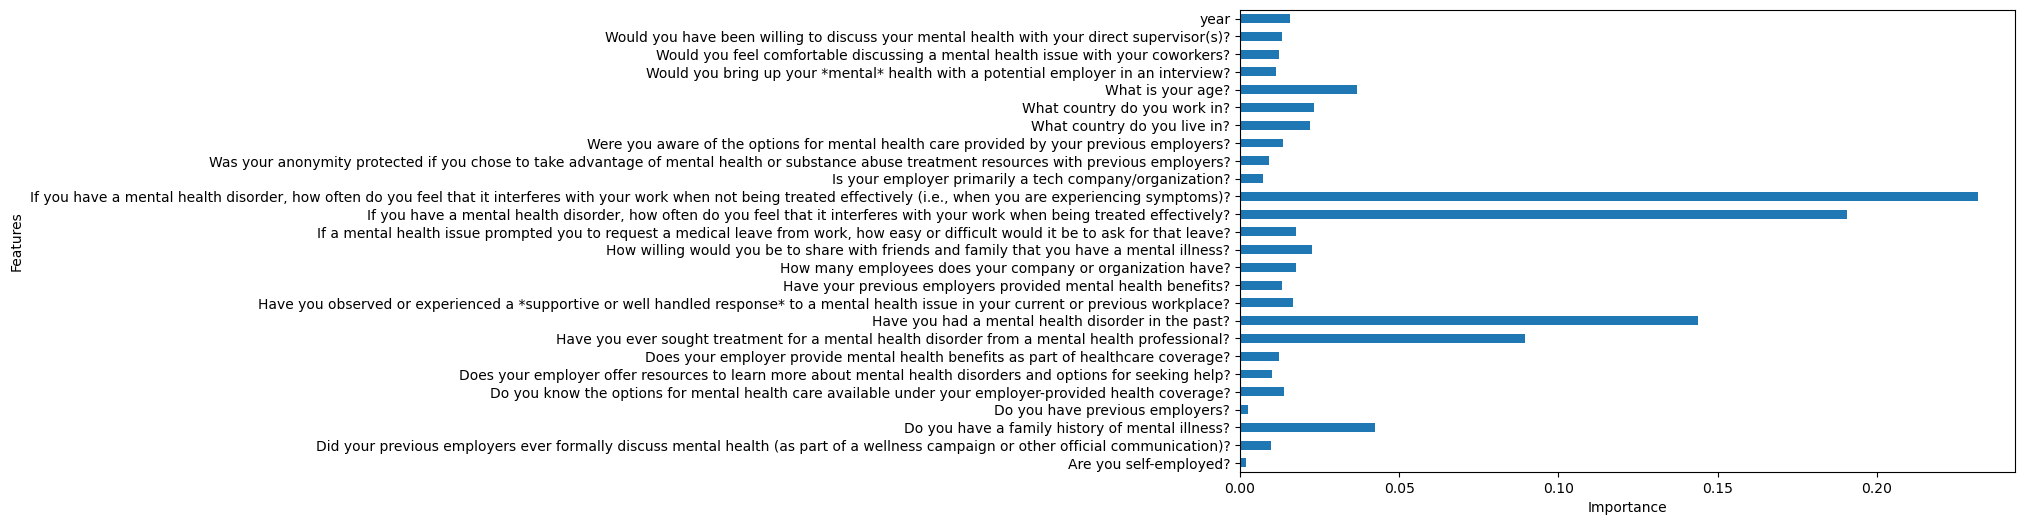

In [428]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.plot(kind='barh',figsize=(10,6))
plt.xlabel("Importance")
plt.ylabel("Features")
#plt.xticks(rotation=90)
plt.show()


## Goal 2: Sentence-BERT

In [439]:
copy = df_filtered.copy()

In [440]:
texts = copy["all_text"]

# <span style="color:red">TODO: 2020-2023 combine free-text into one column for each year and then add all together </span>


In [ ]:
# UNIQUE_THRESHOLD = 50       # columns with > 50 unique values are likely free text
# AVG_LENGTH_THRESHOLD = 20   # average length > 20 characters are likely free text

# exclude_free_text = {
#     "What country do you live in?",
#     "What country do you work in?",
#     "If you live in the United States, which state or territory do you live in?",
#     "If yes, what condition(s) have you been diagnosed with?", # this would be data leakage
#     "If maybe, what condition(s) do you believe you have?", # this also
#     "What US state or territory do you work in?",
#     "What is your age?",
#     "What is your gender?",
#     "SurveyID",
#     "UserID"
# }
# free_text_cols = []

# for col in df_filtered.columns:
#     if col in exclude_free_text:
#         continue
        
#     num_unique = df_filtered[col].nunique()
#     avg_len = df_filtered[col].astype(str).apply(len).mean()
    
#     if num_unique > UNIQUE_THRESHOLD:
#         free_text_cols.append(col)

# for col in free_text_cols:
#     print("-", col)

In [ ]:
# bad_values = {"-1", ".", " ", "", "nan"}

# def clean_val(v):
#     if pd.isna(v):
#         return None
#     v = str(v).strip()
#     return None if v in bad_values else v

# df_filtered["all_text"] = df_filtered[free_text_cols].apply(
#     lambda row: " ".join(
#         [clean_val(v) for v in row if clean_val(v) is not None]
#     ),
#     axis=1
# )
# df_filtered["all_text"].replace("", np.nan, inplace=True)

# df_filtered.drop(columns=free_text_cols, inplace=True)

# print("Column 'all_text' created and free-text columns dropped.")